In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

import gizmo_analysis as gizmo
import utilities as ut

from func import *
from IPython.utils import io

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Define plotting style
import matplotlib as mpl
from matplotlib import colors
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['patch.linewidth'] = 1

In [2]:
unit_time = 0.978 # [Gyr], as set in Gadget

# make these consistent with gizmo.params
start_time = 0
end_time = 13
time_step = 0.1
time_array = np.arange(start_time, end_time+1, time_step)*unit_time

In [3]:
sim_dir = '/home/chainje/thesis/simulation/halos_only'
mw, sgr = create_galaxy_arrays(f"{sim_dir}/combined", 100000, 1000, 10000, 100, time_array)

In [27]:
# Check that the masses look correct
print(f"MW total halo mass:  {np.average([sum(snap['dark']['mass']) for snap in mw]):.3e} (expect 1.25e12)")
print(f"MW total disk mass:  {np.average([sum(snap['star']['mass']) for snap in mw]):.3e} (expect 8.125e10)")
print(f"Sgr total halo mass: {np.average([sum(snap['dark']['mass']) for snap in sgr]):.3e} (expect 1.3e10)")
print(f"Sgr total disk mass: {np.average([sum(snap['star']['mass']) for snap in sgr]):.3e} (expect 7.8e8)")

MW total halo mass:  1.188e+12 (expect 1.25e12)
MW total disk mass:  8.128e+10 (expect 8.125e10)
Sgr total halo mass: 1.250e+10 (expect 1.3e10)
Sgr total disk mass: 8.137e+08 (expect 7.8e8)


# Halo

In [4]:
def nfw_dist(r, sgr=True):
    """
    Eq. 26, Wang 2020 (in GalactICS/Papers); values taken from Dierickx and Loeb 2017
                                     MW            Sgr
    M_200  Virial mass               1e12 M_\odot  1e10 M_\odot
    r_200  Virial radius             206 kpc       44 kpc
    c      concentration parameter   10            8
    """
    if sgr: M_200, r_200, c = 1e10, 44, 8
    else:   M_200, r_200, c = 1e12, 206, 10
    f = lambda c: np.log1p(c) - c / (1+c)
    x = r * c / r_200
    return M_200 / (4*np.pi*f(c)*r_200) * c*x / (r * (1+x))**2

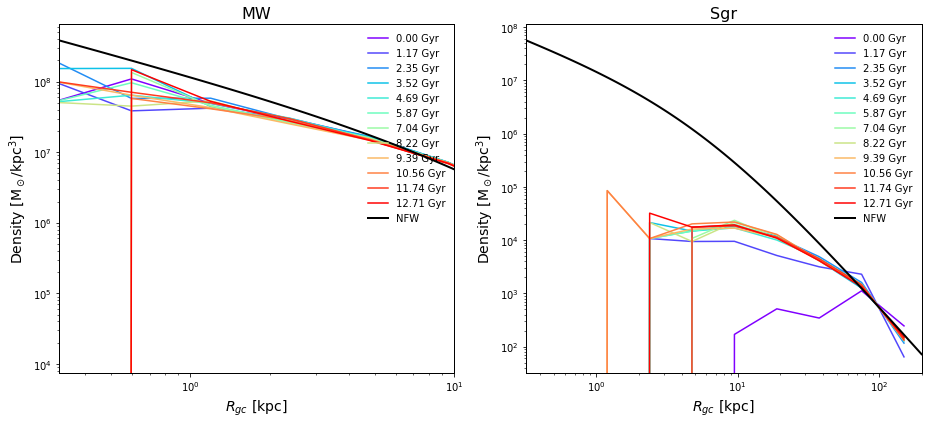

In [10]:
def make_density_hist(ls, min_radius, max_radius, nbins):
    hist, bin_edges = np.histogram(ls['position.sph'][:,0], 
                                   bins=np.logspace(np.log10(min_radius), np.log10(max_radius), nbins+1), 
                                   weights=ls['mass'])
    Rminlist = bin_edges[:-1]
    Rmaxlist = bin_edges[1:]
    Rcenterlist = (Rmaxlist + Rminlist) / 2
    shell_vol_list = 4*np.pi/3 * (Rmaxlist**3 - Rminlist**3)
    return Rcenterlist, np.divide(hist, shell_vol_list)


def plot_halo_density_hist(ax, snaps, sgr=True, title='Mass density', xlim=None, ylim=None, scale='log'):
    ilist = list(range(0, len(snaps), 12)) + [len(snaps) - 1]
    colors = plt.cm.rainbow(np.linspace(0, 1, max(ilist)+1))
    for i in ilist:
        radii, densities = make_density_hist(snaps[i]['dark'], 0.2, 200, 10)
        ax.plot(radii, densities, color=colors[i], label=f"{time_array[i]:.2f} Gyr", linewidth=1.5)

    if xlim is not None:
        r = np.geomspace(xlim[0], xlim[1], 101)
    else:
        r = np.geomspace(0.2, 10, 101)
    ax.plot(r, nfw_dist(r, sgr=sgr), 'k', label='NFW')

    ax.set_xscale(scale)
    ax.set_yscale(scale)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('$R_{gc}$ [kpc]', fontsize=14)
    ax.set_ylabel('Density [M$_\odot$/kpc$^3$]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(frameon=False, loc='upper right', fontsize=10)


f, axs = plt.subplots(1, 2, figsize=(13,6), tight_layout=True)
plot_halo_density_hist(axs[0], mw, sgr=False, xlim=[10**(-0.5), 10], title='MW')
plot_halo_density_hist(axs[1], sgr, sgr=True, xlim=[10**(-0.5), 2*10**(2)], title='Sgr')
plt.show()

# Disk

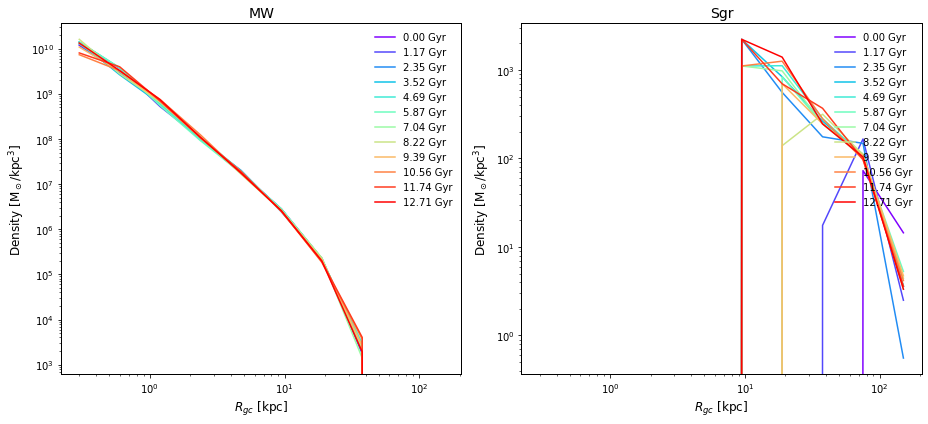

In [11]:
def plot_disk_density_hist(ax, snaps, sgr=True, title='Mass density', xlim=None, ylim=None, scale='log'):
    ilist = list(range(0, len(snaps), 12)) + [len(snaps) - 1]
    colors = plt.cm.rainbow(np.linspace(0, 1, max(ilist)+1))
    for i in ilist:
        radii, densities = make_density_hist(snaps[i]['star'], 0.2, 200, 10)
        ax.plot(radii, densities, color=colors[i], label=f"{time_array[i]:.2f} Gyr", linewidth=1.5)

    ax.set_xscale(scale)
    ax.set_yscale(scale)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('$R_{gc}$ [kpc]', fontsize=12)
    ax.set_ylabel('Density [M$_\odot$/kpc$^3$]', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(frameon=False, loc='upper right', fontsize=10)


f, axs = plt.subplots(1, 2, figsize=(13,6), tight_layout=True)
plot_disk_density_hist(axs[0], mw, sgr=False, title='MW')
plot_disk_density_hist(axs[1], sgr, sgr=True, title='Sgr')
plt.show()

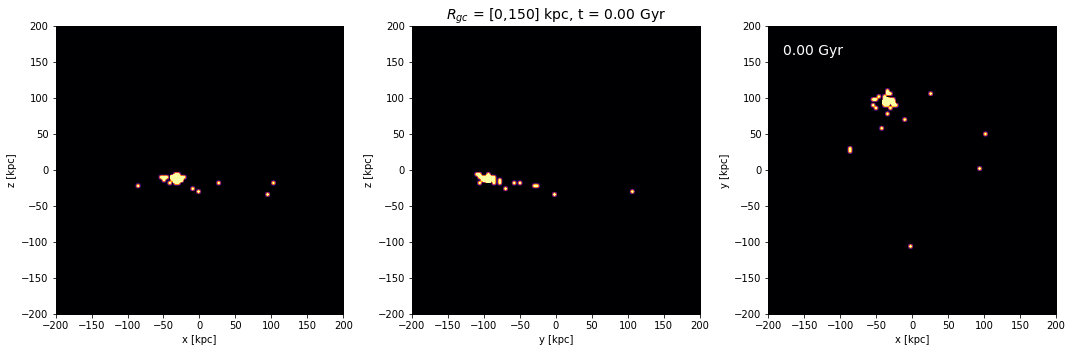

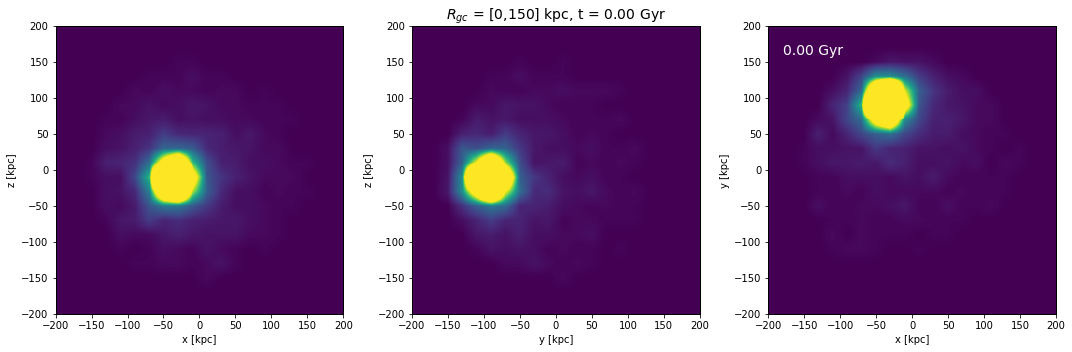

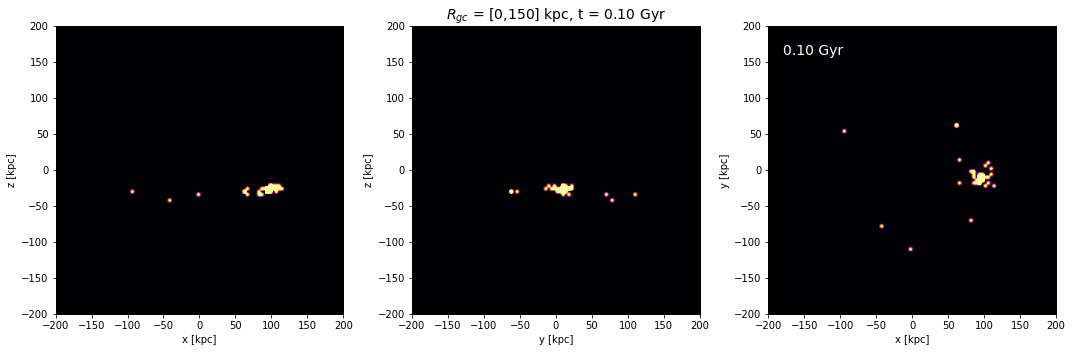

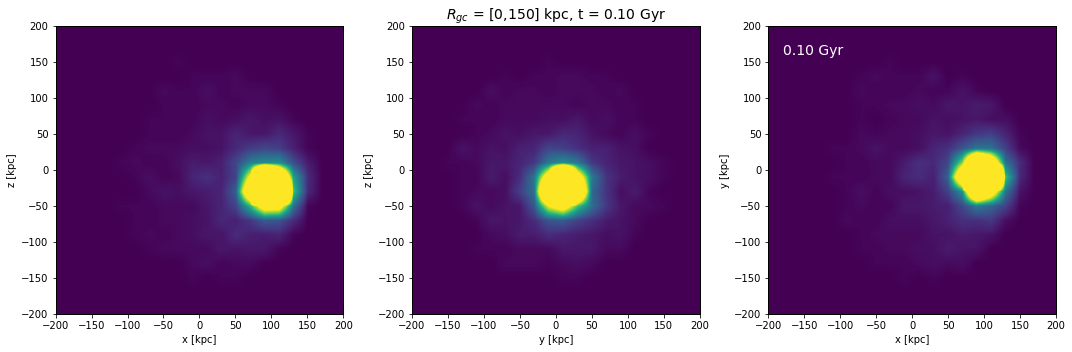

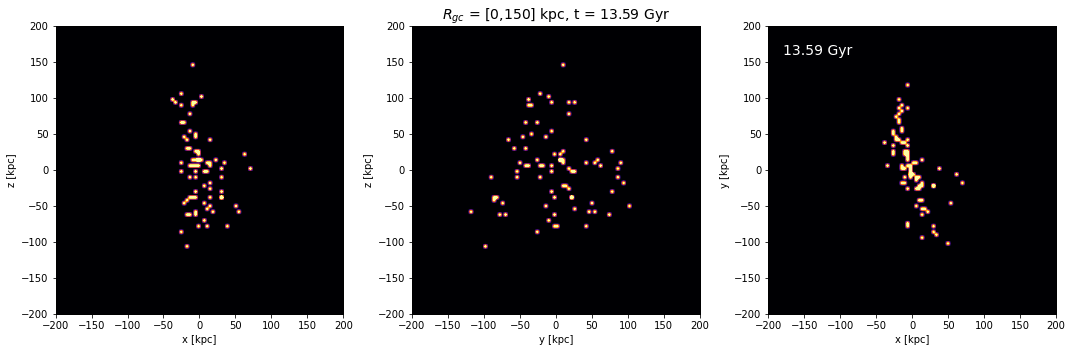

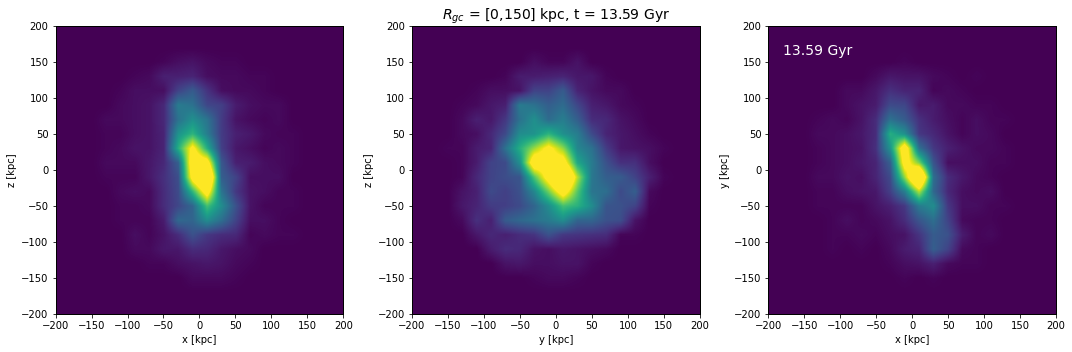

In [20]:
def plot_2D_histogrammer(snap, Rgc_min, Rgc_max, limits, nbins=500):
    mask = (snap['position.sph'][:,0] < Rgc_max) & (snap['position.sph'][:,0] > Rgc_min)
    pos = snap['position'][mask]
    hist, (xs, ys, zs) = np.histogramdd([*pos.T], range=limits, normed=False, bins=nbins)
    hist /= np.diff(xs)[0] * np.diff(ys)[0] * np.diff(zs)[0]
    return hist

def plot_2D_subplotter(ax, hist, dims, lims, cmap, vrange):
    dim_project = np.setdiff1d([0, 1, 2], dims)
    hist_project = np.max(hist, dim_project[0])

    ax.imshow(hist_project.T, cmap=cmap, aspect=1, vmin=vrange[0], vmax=vrange[1],
               interpolation='bilinear', extent=lims)
    
    dim_names = {0: 'x', 1: 'y', 2: 'z'}
    ax.set_xlabel(f'{dim_names[dims[0]]} [kpc]')
    ax.set_ylabel(f'{dim_names[dims[1]]} [kpc]')

def plot_2D_image(ls, snap_idx, Rgc_limits, part='star', nbins=500, vrange=None):
    
    dim_to_plot = [[0, 2], [1, 2], [0, 1]]
    Rgc_min = Rgc_limits[0]
    Rgc_max = Rgc_limits[1]
    
    if part == 'star':
        color_map =  plt.cm.inferno 
        xrange = [200,200,200]
        if vrange is None: vrange = [0, 1e2]

    elif part == 'dark':
        color_map = plt.cm.viridis # plt.get_cmap('bbw')
        xrange = [200, 200, 200]
        if vrange is None: vrange = [0, 10]

    limits = np.array([[-x, x] for x in xrange])

    my_cmap = copy.copy(color_map) # copy the default cmap
    my_cmap.set_bad((1e-4, 1e-4, 1e-4)) # so that all bad pixels (i.e., with values = 0) show up black

    # histogram the data in 3D position space
    hist_values = plot_2D_histogrammer(ls[snap_idx][part], Rgc_min, Rgc_max, limits, nbins=nbins)

    fig, axs = plt.subplots(1, len(dim_to_plot), figsize=(15, 10), tight_layout=True)
    for j in range(len(dim_to_plot)):
        lims = np.concatenate(limits[dim_to_plot[j]])
        plot_2D_subplotter(axs[j], hist_values, dim_to_plot[j], lims, my_cmap, vrange)
    
    axs[2].text(-xrange[0]*0.9, xrange[0]*0.8, f"{time_array[snap_idx]:.2f} Gyr", color='white', fontsize=14)
    axs[1].set_title('$R_{gc}$ = ' f'[{Rgc_min},{Rgc_max}] kpc, t = {time_array[snap_idx]:.2f} Gyr', fontsize=14)
    return fig


# plot_2D_image(mw, -1, [0, 150], nbins=100); plt.show()
# plot_2D_image(mw, -1, [0, 150], part='dark', nbins=200, vrange=[0, 3]); plt.show()

plot_2D_image(sgr, 0, [0, 150], nbins=100, vrange=[0, 0.01]); plt.show()
plot_2D_image(sgr, 0, [0, 150], part='dark', nbins=20, vrange=[0, 0.01]); plt.show()

plot_2D_image(sgr, 1, [0, 150], nbins=100, vrange=[0, 0.01]); plt.show()
plot_2D_image(sgr, 1, [0, 150], part='dark', nbins=20, vrange=[0, 0.01]); plt.show()

plot_2D_image(sgr, -1, [0, 150], nbins=100, vrange=[0, 0.01]); plt.show()
plot_2D_image(sgr, -1, [0, 150], part='dark', nbins=20, vrange=[0, 0.01]); plt.show()

In [24]:
def make_2D_movie(ls, frames, Rgc_limits, part='star', nbins=100, vrange=None):

    dim_to_plot = [[0, 2], [1, 2], [0, 1]]
    Rgc_min = Rgc_limits[0]
    Rgc_max = Rgc_limits[1]

    if part == 'star':
        color_map =  plt.cm.inferno 
        xrange = [150, 150, 150]
        if vrange is None: vrange = [0, 1e2]

    elif part == 'dark':
        color_map = plt.cm.viridis # plt.get_cmap('bbw')
        xrange = [200, 200, 200]
        if vrange is None: vrange = [0, 10]

    limits = np.array([[-x, x] for x in xrange])
    my_cmap = copy.copy(color_map)      # copy the default cmap
    my_cmap.set_bad((1e-4, 1e-4, 1e-4)) # so all bad pixels (value = 0) show up black

    fig, axs = plt.subplots(1, len(dim_to_plot), figsize=(12, 8), tight_layout=True)

    def init():
        return fig,

    def update(frame):
        hist_values = plot_2D_histogrammer(ls[frame][part], Rgc_min, Rgc_max, limits, nbins=nbins)
        for j in range(len(dim_to_plot)):
            lims = np.concatenate(limits[dim_to_plot[j]])
            plot_2D_subplotter(axs[j], hist_values, dim_to_plot[j], lims, my_cmap, vrange)
        axs[1].set_title('$R_{gc}$ = ' f'[{Rgc_min},{Rgc_max}] kpc, t = {time_array[frame]:.2f} Gyr', fontsize=14)
        return fig,

    ani = FuncAnimation(fig, update, frames=frames, init_func=init, blit=True)
    return ani.to_html5_video()

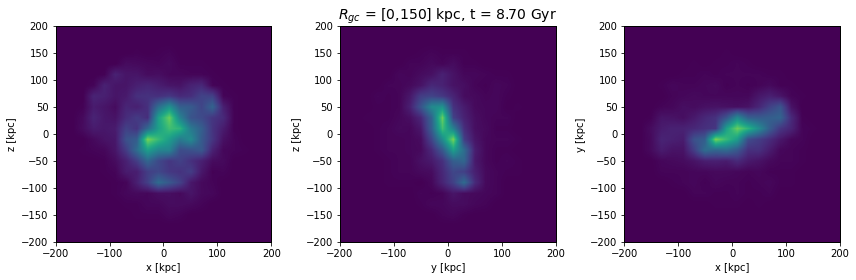

In [31]:
HTML(make_2D_movie(sgr, range(0, 90), [0, 150], part='dark', nbins=20, vrange=[0, 0.02]))

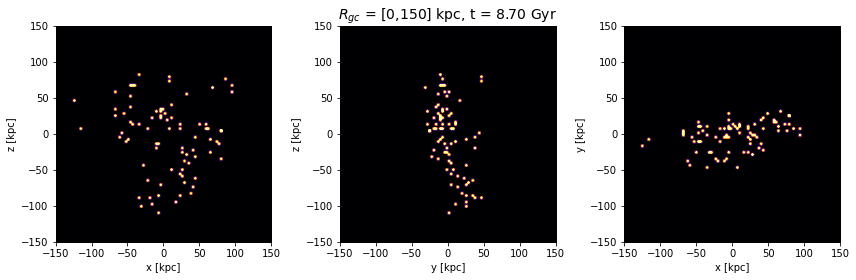

In [32]:
HTML(make_2D_movie(sgr, range(0, 90), [0, 150], part='star', nbins=100, vrange=[0, 0.02]))

In [ ]:
HTML(make_2D_movie(mw, range(0, len(mw), 5), [0, 15], part='dark', nbins=200, vrange=[0, 3]))